# Setup

In [8]:
import os
import time
import numpy as np
import logging
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.losses.numpy import mae, mse, mape

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
ticker = "IYR"

# Load Dataset

In [10]:
def load_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    close_prices = stock_data[['Close']].reset_index()
    close_prices = close_prices.rename(columns={"Date": "ds", "Close": "y"})
    close_prices['ds'] = pd.to_datetime(close_prices['ds'])
    close_prices = close_prices.dropna()
    return close_prices


def fill_missing(df, start_date, end_date):
    full_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    df = df.set_index('ds').reindex(full_date_range).reset_index()
    df.columns = ['ds', 'y']
    df['y'] = df['y'].fillna(method='ffill').fillna(method='bfill')
    return df


def prepare_data(ticker):
    train_start_date = "2024-01-01"
    train_end_date = "2024-06-08"

    test_start_date = "2024-06-01"
    test_end_date = "2024-06-08"

    train_df = load_stock_data(ticker, train_start_date, train_end_date)
    test_df = load_stock_data(ticker, test_start_date, test_end_date)

    train_df = fill_missing(train_df, train_start_date, train_end_date)
    test_df = fill_missing(test_df, test_start_date, test_end_date)

    train_df['unique_id'] = ticker
    test_df['unique_id'] = ticker
    
    return train_df, test_df

In [11]:
train_df, test_df = prepare_data(ticker)
print(test_df)

          ds          y unique_id
0 2024-06-01  86.430000       IYR
1 2024-06-02  86.430000       IYR
2 2024-06-03  86.430000       IYR
3 2024-06-04  87.199997       IYR
4 2024-06-05  86.989998       IYR
5 2024-06-06  87.129997       IYR
6 2024-06-07  86.430000       IYR
7 2024-06-08  86.430000       IYR


/tmp/ipykernel_1348272/3388411697.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['y'] = df['y'].fillna(method='ffill').fillna(method='bfill')
/tmp/ipykernel_1348272/3388411697.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['y'] = df['y'].fillna(method='ffill').fillna(method='bfill')


# Load Pretrained Model & Predict

In [12]:
def load_and_predict_model(test_df):
    nf = NeuralForecast.load(path=f'./checkpoints/{ticker}/')
    forecasts = nf.predict(futr_df=test_df).reset_index()
    return forecasts

In [13]:
def save_csv(forecasts, csv_path):
    df = pd.DataFrame(forecasts)
    df.to_csv(csv_path, index=False)

In [14]:
forecasts = load_and_predict_model(test_df)
print(forecasts)
save_csv(forecasts, csv_path=f"./result/{ticker}.csv")

/home/cathyjeon/anaconda3/envs/etf/lib/python3.10/site-packages/neuralforecast/common/_base_model.py:458: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  content = torch.load(

Failed to load GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D(nf=2304, nx=768)
        (c_proj): Conv1D(nf=768, nx=768)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D(nf=3072, nx=768)
        (c_proj): Conv1D(nf=768, nx=3072)
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
). Loading the default model (openai-community/gpt2)...


/home/cathyjeon/anaconda3/envs/etf/lib/python3.10/site-packages/neuralforecast/core.py:940: UserWarning: Dropped 1 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]


Predicting: |          | 0/? [00:00<?, ?it/s]

  unique_id         ds    TimeLLM
0       IYR 2024-06-02  85.337723
1       IYR 2024-06-03  86.214973
2       IYR 2024-06-04  85.196777
3       IYR 2024-06-05  86.325882
4       IYR 2024-06-06  84.287399
5       IYR 2024-06-07  86.520370
6       IYR 2024-06-08  86.212975


/home/cathyjeon/anaconda3/envs/etf/lib/python3.10/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


# Show Results

In [15]:
def load_csv(csv_path):
    forecasts = pd.read_csv(csv_path)
    forecasts["ds"] = pd.to_datetime(forecasts["ds"], errors="coerce")
    return forecasts

In [16]:
def eval_model(test_df, forecasts):
    mae_value = mae(test_df['y'], forecasts['TimeLLM'])
    mse_value = mse(test_df['y'], forecasts['TimeLLM'])
    mape_value = mape(test_df['y'], forecasts['TimeLLM'])

    return mae_value, mse_value, mape_value

In [19]:
def plot_forecast(train_df, forecasts, mae_value, mse_value, mape_value):
    plt.figure(figsize=(12, 6))

    plt.plot(train_df["ds"], train_df["y"], label="Actual", color="#2496ED", linestyle="-")
    plt.plot(forecasts["ds"], forecasts["TimeLLM"], label="Prediction (TimeLLM)", color="#FF6A6A", linestyle="-")

    plt.axvline(x=forecasts["ds"][0], color="gray", linestyle=":")

    plt.title("Train and Prediction Visualization", fontsize=12)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.xticks(rotation=45)

    metrics_text = f"MAE: {mae_value:.2f}\nMSE: {mse_value:.2f}\nMAPE: {mape_value:.2f}"
    plt.plot([], [], ' ', label=metrics_text)
    plt.legend(fontsize=12)

    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()

    plt.show()

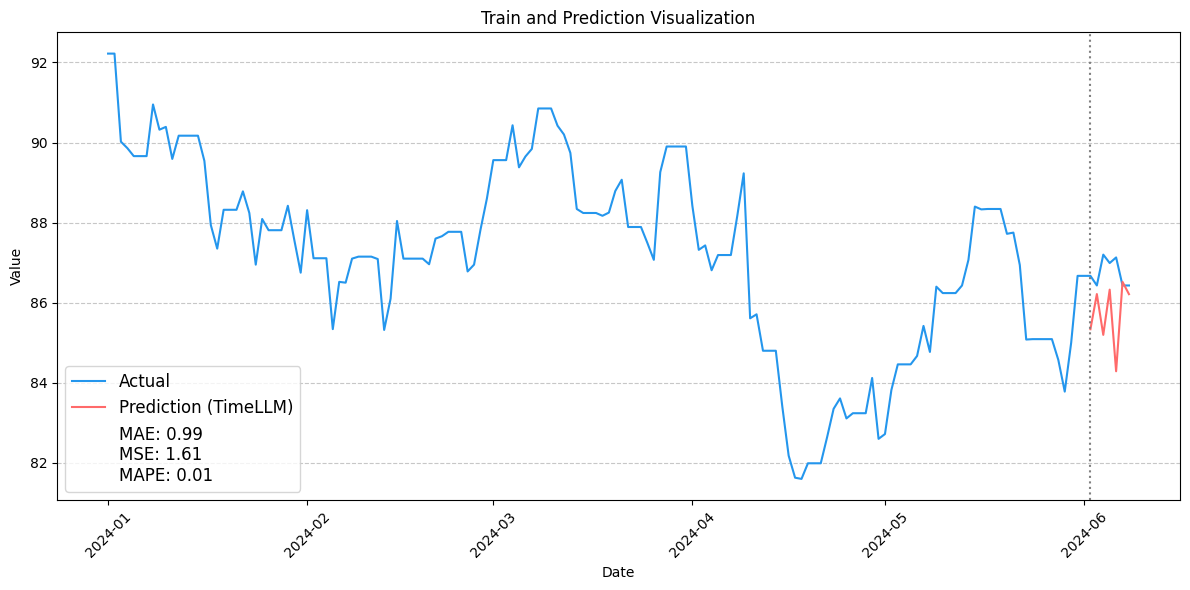

In [20]:
forecasts = load_csv(csv_path=f"./result/{ticker}.csv")
mae_value, mse_value, mape_value = eval_model(test_df, forecasts)
plot_forecast(train_df, forecasts, mae_value, mse_value, mape_value)